In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-future-prices/future-gc00-daily-prices.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [14]:
csv_path="/kaggle/input/gold-future-prices/future-gc00-daily-prices.csv"

In [15]:
# Or your full path
data = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)


In [16]:
# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [17]:
data

,Open,High,Low,Close
Date,,,,
2009-04-24,905.50,915.40,904.20,914.10
2009-04-27,915.00,919.70,905.80,908.20
2009-04-28,907.20,907.70,884.60,893.60
2009-04-29,894.00,904.00,888.30,900.50
2009-04-30,898.60,900.80,880.10,891.20
...,...,...,...,...
2024-02-02,"2,072.00","2,074.70","2,044.20","2,053.70"
2024-02-05,"2,057.90","2,059.10","2,030.80","2,042.90"
2024-02-06,"2,041.40","2,055.30","2,038.80","2,051.40"


# Data Preprocessing

In [22]:
# Clean the "Close" column
data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)

<ipython-input-22-112cefec2dab>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)


**data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)**

Replaces any infinite values (positive or negative) with NaN.

Infinite values may occur from bad calculations (e.g., division by zero or log of zero).

 **data.dropna(subset=["Close"], inplace=True)**
Drops rows from the dataset where the "Close" column has a NaN value.

Cleans the data to ensure you don’t feed missing or bad values into your analysis/model.

# Create a time plot
**Now is a good time to create a time plot so we can see the series that we are working with:** 

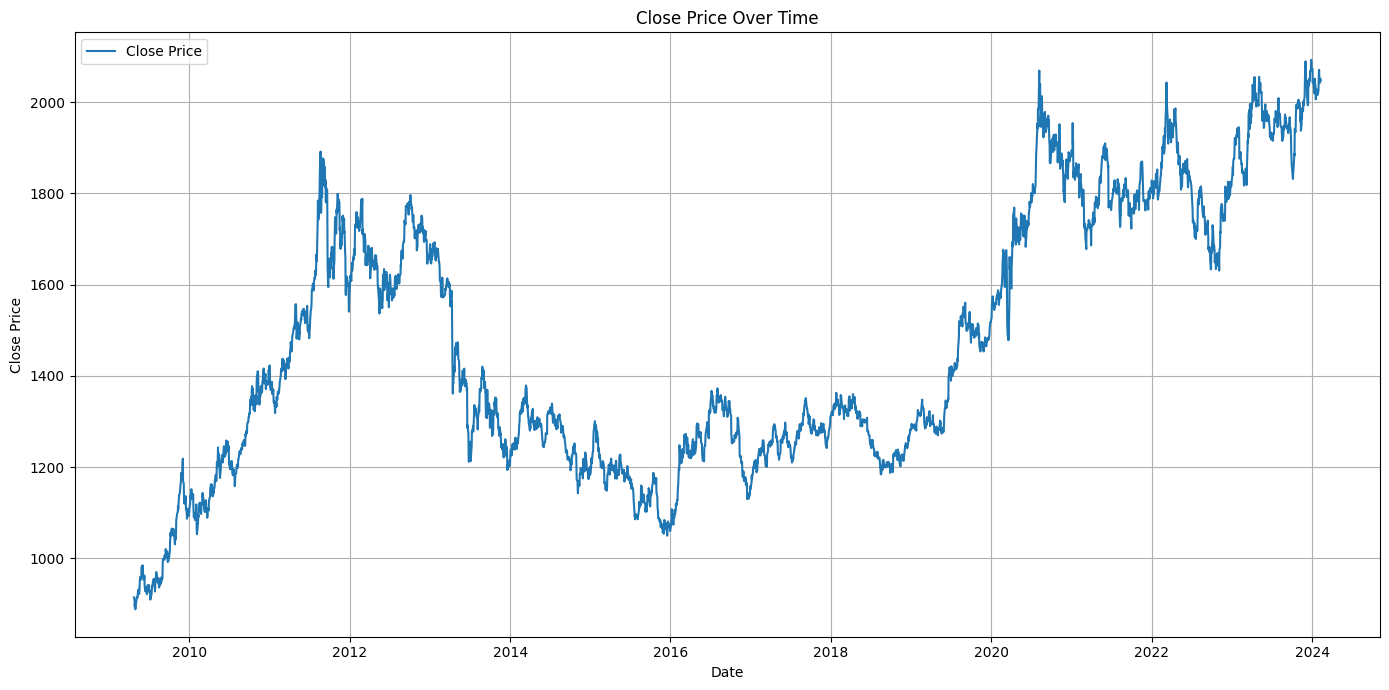

In [25]:
## Plotting the original close price

plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.legend()                                   # Show the legend
plt.grid(True)                                 # Add gridlines
plt.tight_layout() 
plt.show()

**Check for stationarity and perform differencing if necessary**

In [26]:
# Perform the Augmented Dickey-Fuller test on the original series

result_original=adfuller(data['Close'])

print(f"ADF Statistics (Original):{result_original[0]:.4f}")
print(f"p-values (original):{result_original[1]:.4f}")

if result_original[1]<0.05:
    print("Interpretation: The original series is stationary.\n")
else:
    print("Interpretation: The Original Series is non Stationary.\n")

## Apply First order differeencing 

data['Close_diff']=data['Close'].diff()

## Perfoem the ADF test on the diffwewnced series

result_dff=adfuller(data['Close_diff'].dropna())
print(f"ADF Stats (Differenced): {result_dff[0]:.4f}")
print(f"p-values (Differennced): {result_dff[1]:.4f}")

if result_dff[1]<0.05:
     print("Interpretation: The original series is stationary.\n")
else:
    print("Interpretation: The Original Series is non Stationary.\n")

ADF Statistics (Original):-1.4367
p-values (original):0.5646
Interpretation: The Original Series is non Stationary.

ADF Stats (Differenced): -19.1308
p-values (Differennced): 0.0000
Interpretation: The original series is stationary.



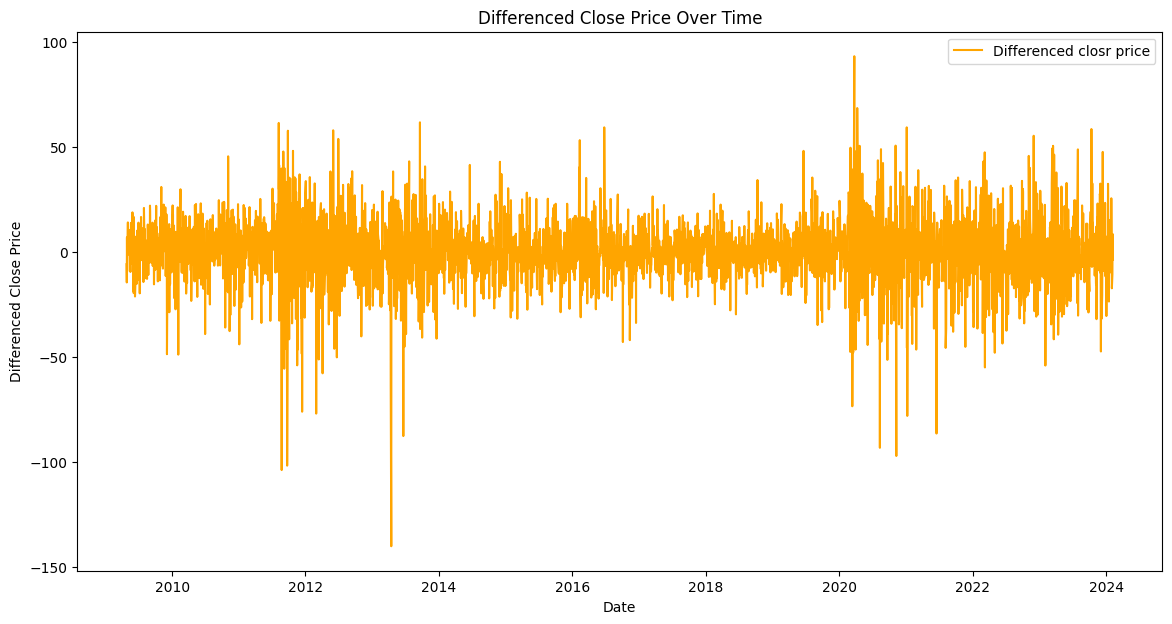

In [27]:
## Plotting the differenced Close Price

plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close_diff'], label="Differenced closr price", color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

# Model identification

**When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model.**

**The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags**.

**The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary**.

**The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations**.

# Finding the ARIMA terms

We use tools like **ACF** (Autocorrelation Function) and **PACF** (Partial Autocorrelation Function) to determine the values of p, d, and q. The number of lags where ACF cuts off is q, and where PACF cuts off is p. We also have to choose the appropriate value for d by creating a situation where, after differencing, the data resembles white noise. For our data, we choose 1 for both p and q because we see a significant spike in the first lag for each.

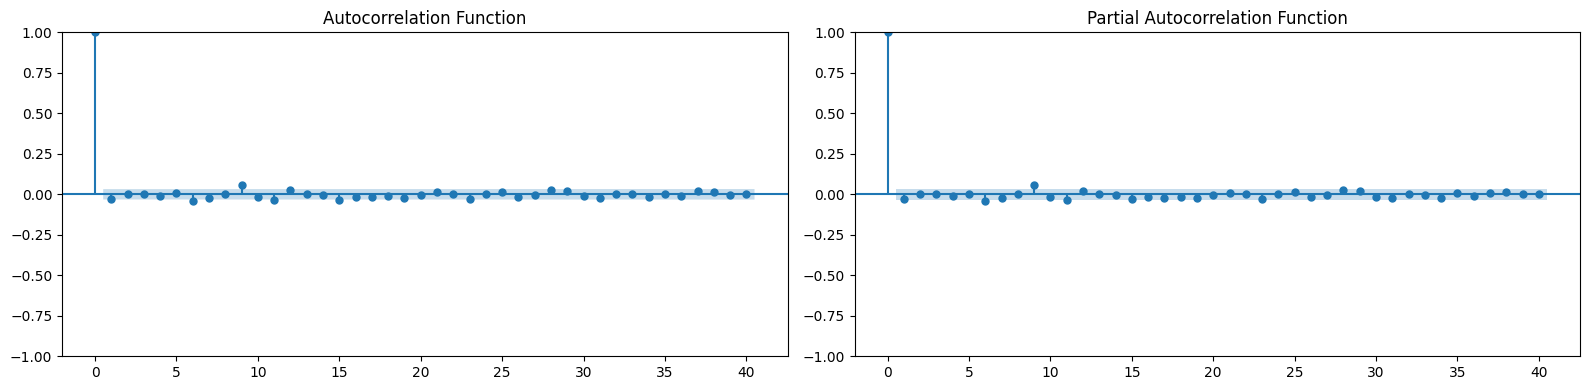

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Difference the Close price
data['Close_diff'] = data['Close'].diff()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function")

# PACF plot
plot_pacf(data['Close_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function")

plt.tight_layout()
plt.show()


# Forecasting

In [34]:
# Splitting the data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [35]:
train_size

2979

In [38]:
train.shape

(2979, 5)

In [39]:
test.shape

(745, 5)

In [42]:
# Fit ARIMA model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 2. Visualize our time series

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


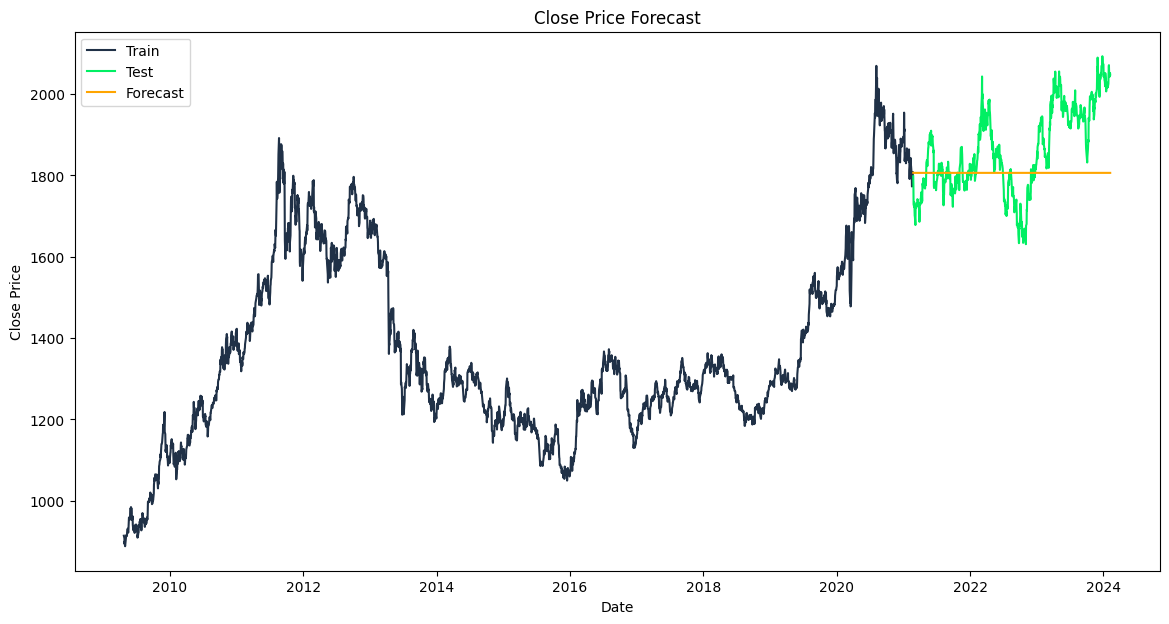

In [43]:
forecast =model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 3. Evaluate model statistics

In [44]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24602.974260667695
BIC: 24620.971282307426


In [45]:
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 118.5339
